In [5]:
! pip install -q kaggle

In [6]:
from google.colab import files

In [7]:
!pip install opendatasets

In [8]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/bazeerr/celeba")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: haarshgupta
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bazeerr/celeba


100%|██████████| 1.32G/1.32G [00:21<00:00, 66.8MB/s]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision
import numpy as np

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CelebDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        # Get all image file paths from the directory
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        # Apply the transform if provided
        if self.transform:
            image = self.transform(image)

        return image

In [11]:
# Define transformation (resize , crop , convert to tensor , normalize)

transform = transforms.Compose([
    transforms.Resize(64) ,#Resize image of 64X64
    transforms.CenterCrop(64), # Crop centre to 64X64
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5 , 0.5 , 0.5] , std = [0.5 , 0.5 , 0.5]) #normalize to [-1,1]
])


In [12]:
path = "/content/celeba/img_align_celeba"
dataset = CelebDataset(root_dir = path , transform = transform)

In [13]:
len(dataset)

202599

In [14]:
image = dataset.__getitem__(1)
print(image)

tensor([[[-0.9373, -0.9451, -0.9373,  ...,  0.0745,  0.0745,  0.0588],
         [-0.9451, -0.9529, -0.9451,  ...,  0.0667,  0.0745,  0.0745],
         [-0.9529, -0.9529, -0.9451,  ...,  0.0745,  0.0824,  0.0745],
         ...,
         [-0.9373, -0.9373, -0.9451,  ...,  0.0353,  0.0275,  0.0196],
         [-0.9451, -0.9529, -0.9137,  ..., -0.0275,  0.0196,  0.0118],
         [-0.8980, -0.7804, -0.6078,  ..., -0.3412, -0.1608, -0.0353]],

        [[-0.9529, -0.9608, -0.9529,  ...,  0.1059,  0.1059,  0.0902],
         [-0.9451, -0.9529, -0.9451,  ...,  0.0980,  0.1059,  0.1059],
         [-0.9451, -0.9451, -0.9373,  ...,  0.1059,  0.1137,  0.1059],
         ...,
         [-0.9294, -0.9294, -0.9294,  ...,  0.0667,  0.0588,  0.0588],
         [-0.9294, -0.9373, -0.8980,  ...,  0.0039,  0.0588,  0.0588],
         [-0.8980, -0.7804, -0.6000,  ..., -0.3176, -0.1373,  0.0039]],

        [[-0.9451, -0.9529, -0.9451,  ...,  0.1765,  0.1765,  0.1608],
         [-0.9294, -0.9373, -0.9294,  ...,  0

In [15]:
image.shape

torch.Size([3, 64, 64])

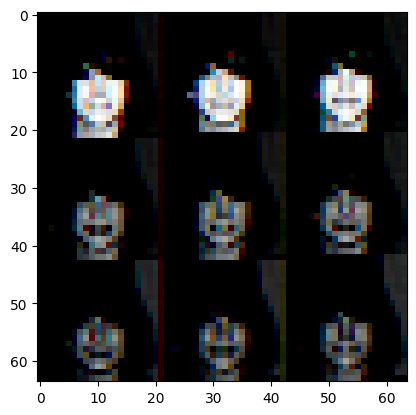

In [16]:
import matplotlib.pyplot as plt
plt.imshow(image.reshape(64 , 64 , 3))

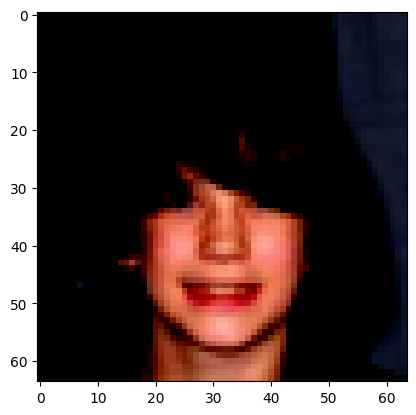

In [17]:
img_np = image.permute(1, 2, 0).numpy()
plt.imshow(img_np)

In [18]:
dataloader = DataLoader(dataset , batch_size = 128 , shuffle = True)

print(f"Total number of image loaded : {len(dataset)}")

Total number of image loaded : 202599


In [19]:
# generator model

class Generator(nn.Module):
    def __init__(self , z_dim = 100 , img_channel = 3):
        super(Generator , self).__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim , 256),
            nn.ReLU(True),
            nn.Linear(256 , 512),
            nn.ReLU(True),
            nn.Linear(512 , 1024),
            nn.ReLU(True),
            nn.Linear(1024 , img_channel * 64 * 64),
            nn.Tanh()
        )

    def forward(self , z):
        img = self.model(z)
        img = img.view(img.size(0) , 3 , 64 , 64)
        return img

In [20]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_channels * 64 * 64, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

In [24]:
# Loss function and optimizers
adversarial_loss = nn.BCELoss()
generator = Generator(z_dim=100)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)


In [25]:
def train(generator, discriminator, dataloader, epochs=5):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)

            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device)).detach()), fake)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device))), valid)
            g_loss.backward()
            optimizer_G.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Optionally, save generated images at each epoch
        save_generated_images(generator, epoch, device)

[Epoch 0/20] [Batch 0/1583] [D loss: 0.6982214450836182] [G loss: 0.679657518863678]
[Epoch 0/20] [Batch 50/1583] [D loss: 0.2958819568157196] [G loss: 1.1558434963226318]
[Epoch 0/20] [Batch 100/1583] [D loss: 0.2028043568134308] [G loss: 1.3625702857971191]
[Epoch 0/20] [Batch 150/1583] [D loss: 0.16578611731529236] [G loss: 1.0259933471679688]
[Epoch 0/20] [Batch 200/1583] [D loss: 0.07446196675300598] [G loss: 2.2146239280700684]
[Epoch 0/20] [Batch 250/1583] [D loss: 0.05465041100978851] [G loss: 3.204669952392578]
[Epoch 0/20] [Batch 300/1583] [D loss: 0.019940929487347603] [G loss: 4.535427093505859]
[Epoch 0/20] [Batch 350/1583] [D loss: 0.282292902469635] [G loss: 1.3336422443389893]
[Epoch 0/20] [Batch 400/1583] [D loss: 0.07198059558868408] [G loss: 1.4538604021072388]
[Epoch 0/20] [Batch 450/1583] [D loss: 0.07794229686260223] [G loss: 4.004377841949463]
[Epoch 0/20] [Batch 500/1583] [D loss: 0.43994998931884766] [G loss: 0.8592621684074402]
[Epoch 0/20] [Batch 550/1583] [D

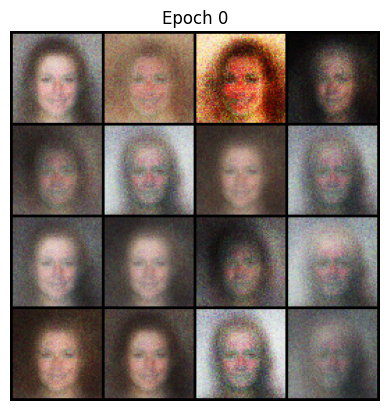

[Epoch 1/20] [Batch 0/1583] [D loss: 0.23394158482551575] [G loss: 2.3036446571350098]
[Epoch 1/20] [Batch 50/1583] [D loss: 0.48644497990608215] [G loss: 3.824069023132324]
[Epoch 1/20] [Batch 100/1583] [D loss: 0.202486053109169] [G loss: 2.5868823528289795]
[Epoch 1/20] [Batch 150/1583] [D loss: 0.25791165232658386] [G loss: 2.4621686935424805]
[Epoch 1/20] [Batch 200/1583] [D loss: 0.34038877487182617] [G loss: 2.823025703430176]
[Epoch 1/20] [Batch 250/1583] [D loss: 0.26879534125328064] [G loss: 2.266934633255005]
[Epoch 1/20] [Batch 300/1583] [D loss: 0.3670562505722046] [G loss: 2.5220274925231934]
[Epoch 1/20] [Batch 350/1583] [D loss: 0.5330314636230469] [G loss: 2.7973055839538574]
[Epoch 1/20] [Batch 400/1583] [D loss: 0.38676270842552185] [G loss: 2.162729501724243]
[Epoch 1/20] [Batch 450/1583] [D loss: 0.30625227093696594] [G loss: 2.0942258834838867]
[Epoch 1/20] [Batch 500/1583] [D loss: 0.3831866383552551] [G loss: 3.0588858127593994]
[Epoch 1/20] [Batch 550/1583] [D 

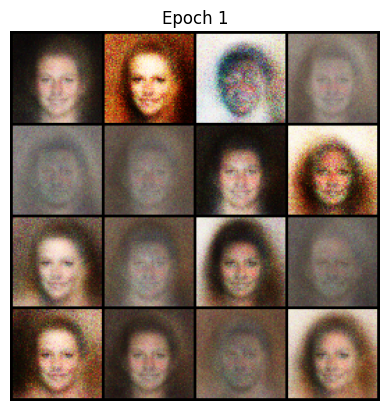

[Epoch 2/20] [Batch 0/1583] [D loss: 0.36989453434944153] [G loss: 3.2574338912963867]
[Epoch 2/20] [Batch 50/1583] [D loss: 0.3662477731704712] [G loss: 2.1544148921966553]
[Epoch 2/20] [Batch 100/1583] [D loss: 0.36970463395118713] [G loss: 1.7700001001358032]
[Epoch 2/20] [Batch 150/1583] [D loss: 0.48800674080848694] [G loss: 2.5380771160125732]
[Epoch 2/20] [Batch 200/1583] [D loss: 0.37996792793273926] [G loss: 1.6099755764007568]
[Epoch 2/20] [Batch 250/1583] [D loss: 0.40035849809646606] [G loss: 2.1193182468414307]
[Epoch 2/20] [Batch 300/1583] [D loss: 0.4897027909755707] [G loss: 2.411334991455078]
[Epoch 2/20] [Batch 350/1583] [D loss: 0.5277608633041382] [G loss: 1.4847835302352905]
[Epoch 2/20] [Batch 400/1583] [D loss: 0.46731436252593994] [G loss: 2.2729527950286865]
[Epoch 2/20] [Batch 450/1583] [D loss: 0.4178121089935303] [G loss: 1.9184069633483887]
[Epoch 2/20] [Batch 500/1583] [D loss: 0.38267162442207336] [G loss: 2.278029441833496]
[Epoch 2/20] [Batch 550/1583] 

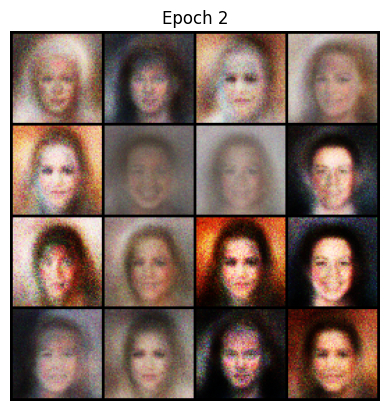

[Epoch 3/20] [Batch 0/1583] [D loss: 0.4824460744857788] [G loss: 2.1432032585144043]
[Epoch 3/20] [Batch 50/1583] [D loss: 0.431758850812912] [G loss: 2.2827606201171875]
[Epoch 3/20] [Batch 100/1583] [D loss: 0.42677831649780273] [G loss: 1.8229466676712036]
[Epoch 3/20] [Batch 150/1583] [D loss: 0.46864601969718933] [G loss: 1.480114459991455]
[Epoch 3/20] [Batch 200/1583] [D loss: 0.4980505704879761] [G loss: 1.8069924116134644]
[Epoch 3/20] [Batch 250/1583] [D loss: 0.4268363118171692] [G loss: 1.5501627922058105]
[Epoch 3/20] [Batch 300/1583] [D loss: 0.5044363737106323] [G loss: 1.753526210784912]
[Epoch 3/20] [Batch 350/1583] [D loss: 0.4298456013202667] [G loss: 1.6262178421020508]
[Epoch 3/20] [Batch 400/1583] [D loss: 0.4715556502342224] [G loss: 1.4718618392944336]
[Epoch 3/20] [Batch 450/1583] [D loss: 0.5158010721206665] [G loss: 1.556945562362671]
[Epoch 3/20] [Batch 500/1583] [D loss: 0.5690740346908569] [G loss: 2.5119130611419678]
[Epoch 3/20] [Batch 550/1583] [D loss

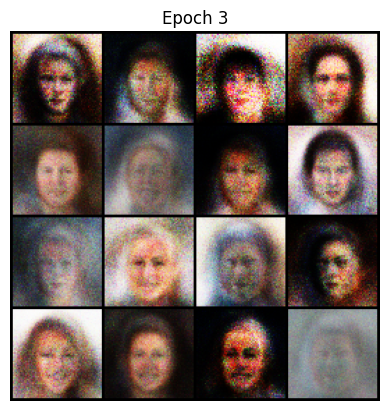

[Epoch 4/20] [Batch 0/1583] [D loss: 0.4926662743091583] [G loss: 1.5289373397827148]
[Epoch 4/20] [Batch 50/1583] [D loss: 0.4353756308555603] [G loss: 1.818821907043457]
[Epoch 4/20] [Batch 100/1583] [D loss: 0.47286921739578247] [G loss: 1.5666042566299438]
[Epoch 4/20] [Batch 150/1583] [D loss: 0.5889015197753906] [G loss: 1.8562841415405273]
[Epoch 4/20] [Batch 200/1583] [D loss: 0.5298230648040771] [G loss: 1.710155725479126]
[Epoch 4/20] [Batch 250/1583] [D loss: 0.47761911153793335] [G loss: 1.6058710813522339]
[Epoch 4/20] [Batch 300/1583] [D loss: 0.5062939524650574] [G loss: 1.790436863899231]
[Epoch 4/20] [Batch 350/1583] [D loss: 0.4861021935939789] [G loss: 1.6147561073303223]
[Epoch 4/20] [Batch 400/1583] [D loss: 0.520135760307312] [G loss: 1.478311538696289]
[Epoch 4/20] [Batch 450/1583] [D loss: 0.41499772667884827] [G loss: 1.2810969352722168]
[Epoch 4/20] [Batch 500/1583] [D loss: 0.5455313920974731] [G loss: 1.7095611095428467]
[Epoch 4/20] [Batch 550/1583] [D loss

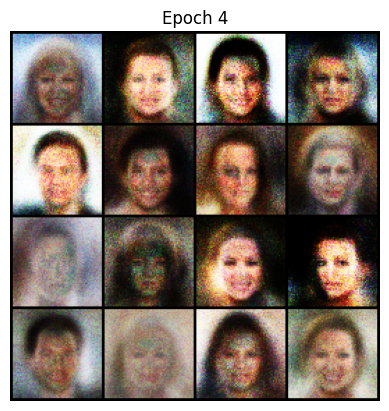

[Epoch 5/20] [Batch 0/1583] [D loss: 0.5354980826377869] [G loss: 1.433935523033142]
[Epoch 5/20] [Batch 50/1583] [D loss: 0.42709866166114807] [G loss: 1.6614090204238892]
[Epoch 5/20] [Batch 100/1583] [D loss: 0.4908599853515625] [G loss: 1.4657570123672485]
[Epoch 5/20] [Batch 150/1583] [D loss: 0.4923798739910126] [G loss: 1.597346544265747]
[Epoch 5/20] [Batch 200/1583] [D loss: 0.5331226587295532] [G loss: 1.7029815912246704]
[Epoch 5/20] [Batch 250/1583] [D loss: 0.47143396735191345] [G loss: 1.695854663848877]
[Epoch 5/20] [Batch 300/1583] [D loss: 0.4923780560493469] [G loss: 1.5119736194610596]
[Epoch 5/20] [Batch 350/1583] [D loss: 0.5372526049613953] [G loss: 1.2878599166870117]
[Epoch 5/20] [Batch 400/1583] [D loss: 0.5585952997207642] [G loss: 1.5407443046569824]
[Epoch 5/20] [Batch 450/1583] [D loss: 0.564018964767456] [G loss: 1.5395617485046387]
[Epoch 5/20] [Batch 500/1583] [D loss: 0.4827793836593628] [G loss: 1.6812310218811035]
[Epoch 5/20] [Batch 550/1583] [D loss

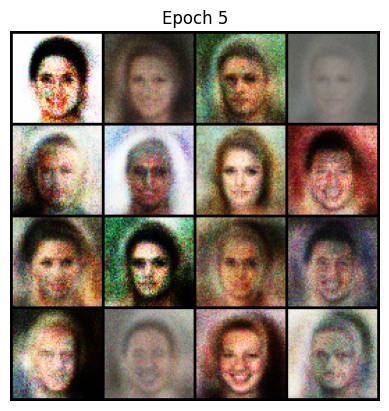

[Epoch 6/20] [Batch 0/1583] [D loss: 0.5123929977416992] [G loss: 1.659738302230835]
[Epoch 6/20] [Batch 50/1583] [D loss: 0.5477669835090637] [G loss: 1.5268259048461914]
[Epoch 6/20] [Batch 100/1583] [D loss: 0.5454777479171753] [G loss: 1.5753309726715088]
[Epoch 6/20] [Batch 150/1583] [D loss: 0.6506659984588623] [G loss: 1.3118036985397339]
[Epoch 6/20] [Batch 200/1583] [D loss: 0.5592026710510254] [G loss: 1.1942782402038574]
[Epoch 6/20] [Batch 250/1583] [D loss: 0.4799174666404724] [G loss: 1.2775192260742188]
[Epoch 6/20] [Batch 300/1583] [D loss: 0.5352124571800232] [G loss: 1.4176654815673828]
[Epoch 6/20] [Batch 350/1583] [D loss: 0.5198126435279846] [G loss: 1.5727156400680542]
[Epoch 6/20] [Batch 400/1583] [D loss: 0.5397874116897583] [G loss: 1.2309114933013916]
[Epoch 6/20] [Batch 450/1583] [D loss: 0.4839746654033661] [G loss: 1.2897427082061768]
[Epoch 6/20] [Batch 500/1583] [D loss: 0.5508562326431274] [G loss: 1.4475306272506714]
[Epoch 6/20] [Batch 550/1583] [D los

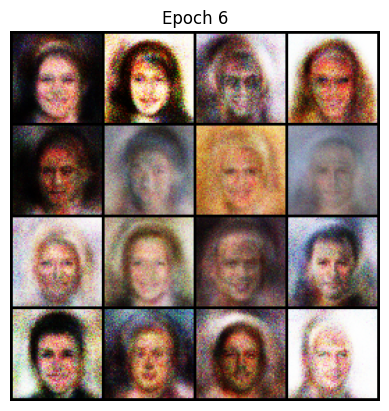

[Epoch 7/20] [Batch 0/1583] [D loss: 0.5338250398635864] [G loss: 1.2956807613372803]
[Epoch 7/20] [Batch 50/1583] [D loss: 0.5196163654327393] [G loss: 1.1718964576721191]
[Epoch 7/20] [Batch 100/1583] [D loss: 0.5397119522094727] [G loss: 1.2536009550094604]
[Epoch 7/20] [Batch 150/1583] [D loss: 0.5748388767242432] [G loss: 1.175765037536621]
[Epoch 7/20] [Batch 200/1583] [D loss: 0.5751370191574097] [G loss: 1.4837474822998047]
[Epoch 7/20] [Batch 250/1583] [D loss: 0.5804601907730103] [G loss: 1.217658281326294]
[Epoch 7/20] [Batch 300/1583] [D loss: 0.5381667613983154] [G loss: 1.4927281141281128]
[Epoch 7/20] [Batch 350/1583] [D loss: 0.5897023677825928] [G loss: 1.4787724018096924]
[Epoch 7/20] [Batch 400/1583] [D loss: 0.5497157573699951] [G loss: 1.160353660583496]
[Epoch 7/20] [Batch 450/1583] [D loss: 0.6179653406143188] [G loss: 1.2636507749557495]
[Epoch 7/20] [Batch 500/1583] [D loss: 0.5648542642593384] [G loss: 1.4608945846557617]
[Epoch 7/20] [Batch 550/1583] [D loss:

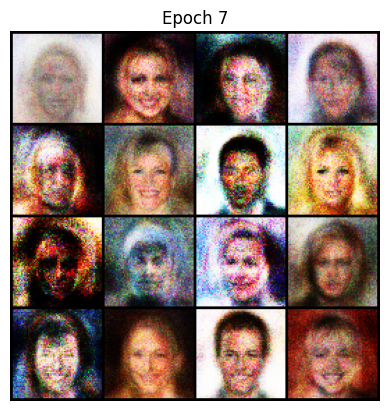

[Epoch 8/20] [Batch 0/1583] [D loss: 0.5245257616043091] [G loss: 1.4310336112976074]
[Epoch 8/20] [Batch 50/1583] [D loss: 0.6378045678138733] [G loss: 1.2583528757095337]
[Epoch 8/20] [Batch 100/1583] [D loss: 0.5611650943756104] [G loss: 1.1708126068115234]
[Epoch 8/20] [Batch 150/1583] [D loss: 0.540644645690918] [G loss: 1.2290338277816772]
[Epoch 8/20] [Batch 200/1583] [D loss: 0.571575403213501] [G loss: 1.304912805557251]
[Epoch 8/20] [Batch 250/1583] [D loss: 0.5696125030517578] [G loss: 1.2343580722808838]
[Epoch 8/20] [Batch 300/1583] [D loss: 0.5711966753005981] [G loss: 1.1698086261749268]
[Epoch 8/20] [Batch 350/1583] [D loss: 0.5316213369369507] [G loss: 1.3843379020690918]
[Epoch 8/20] [Batch 400/1583] [D loss: 0.5130919218063354] [G loss: 1.3343768119812012]
[Epoch 8/20] [Batch 450/1583] [D loss: 0.6470019817352295] [G loss: 1.5442445278167725]
[Epoch 8/20] [Batch 500/1583] [D loss: 0.5565407276153564] [G loss: 1.2329058647155762]
[Epoch 8/20] [Batch 550/1583] [D loss:

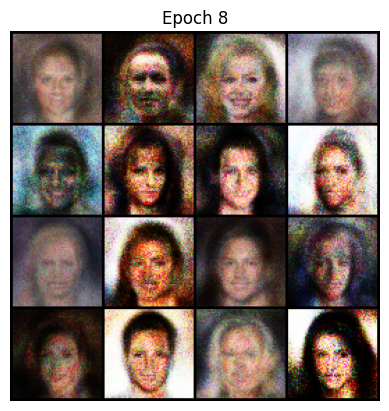

[Epoch 9/20] [Batch 0/1583] [D loss: 0.572376012802124] [G loss: 1.2297908067703247]
[Epoch 9/20] [Batch 50/1583] [D loss: 0.567213773727417] [G loss: 1.32368803024292]
[Epoch 9/20] [Batch 100/1583] [D loss: 0.6271729469299316] [G loss: 1.1833820343017578]
[Epoch 9/20] [Batch 150/1583] [D loss: 0.5580728650093079] [G loss: 1.3542590141296387]
[Epoch 9/20] [Batch 200/1583] [D loss: 0.5753019452095032] [G loss: 1.3496947288513184]
[Epoch 9/20] [Batch 250/1583] [D loss: 0.5887645483016968] [G loss: 0.997077465057373]
[Epoch 9/20] [Batch 300/1583] [D loss: 0.5570806264877319] [G loss: 1.210944652557373]
[Epoch 9/20] [Batch 350/1583] [D loss: 0.5512681603431702] [G loss: 1.0103403329849243]
[Epoch 9/20] [Batch 400/1583] [D loss: 0.5551804304122925] [G loss: 1.1707227230072021]
[Epoch 9/20] [Batch 450/1583] [D loss: 0.6241793632507324] [G loss: 1.2063708305358887]
[Epoch 9/20] [Batch 500/1583] [D loss: 0.5429763793945312] [G loss: 1.0818771123886108]
[Epoch 9/20] [Batch 550/1583] [D loss: 0.

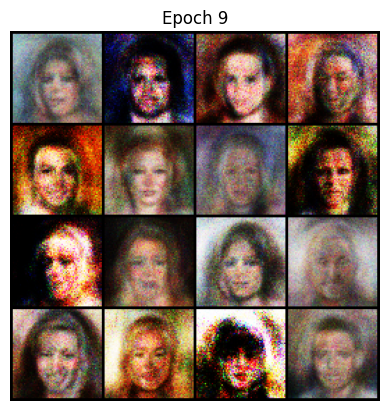

[Epoch 10/20] [Batch 0/1583] [D loss: 0.5311457514762878] [G loss: 1.1053736209869385]
[Epoch 10/20] [Batch 50/1583] [D loss: 0.5547341108322144] [G loss: 1.186845302581787]
[Epoch 10/20] [Batch 100/1583] [D loss: 0.5650740265846252] [G loss: 1.0853588581085205]
[Epoch 10/20] [Batch 150/1583] [D loss: 0.5977753400802612] [G loss: 1.261195421218872]
[Epoch 10/20] [Batch 200/1583] [D loss: 0.6079015731811523] [G loss: 1.257178544998169]
[Epoch 10/20] [Batch 250/1583] [D loss: 0.5257617235183716] [G loss: 1.1724191904067993]
[Epoch 10/20] [Batch 300/1583] [D loss: 0.6118083000183105] [G loss: 1.233568787574768]
[Epoch 10/20] [Batch 350/1583] [D loss: 0.569290041923523] [G loss: 1.2009687423706055]
[Epoch 10/20] [Batch 400/1583] [D loss: 0.5532828569412231] [G loss: 1.1520779132843018]
[Epoch 10/20] [Batch 450/1583] [D loss: 0.5299752354621887] [G loss: 1.165074348449707]
[Epoch 10/20] [Batch 500/1583] [D loss: 0.554847240447998] [G loss: 1.3215116262435913]
[Epoch 10/20] [Batch 550/1583] 

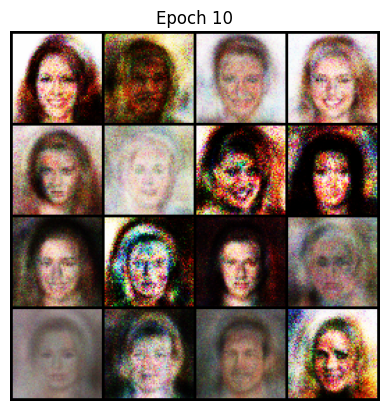

[Epoch 11/20] [Batch 0/1583] [D loss: 0.6562944650650024] [G loss: 1.2758034467697144]
[Epoch 11/20] [Batch 50/1583] [D loss: 0.5759031772613525] [G loss: 1.0372071266174316]


KeyboardInterrupt: 

In [26]:
def save_generated_images(generator, epoch, device, num_images=16):
    z = torch.randn(num_images, 100).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

# Start training
train(generator, discriminator, dataloader, epochs=20)